In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')

import time
#from dython.nominal import associations

In [2]:
data = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(data.shape)
data.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
d1  = data.iloc[0].to_dict()

In [15]:
pd.DataFrame(d1,index=[0])

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [188]:
global_churn = round((data.Churn=='Yes').sum()/data.shape[0],2)
global_churn

0.27

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,recall_score ,f1_score,confusion_matrix,classification_report,precision_score
from sklearn.ensemble import RandomForestClassifier

In [102]:
#my metrics
from my_metrics import tpr,fpr
def best_thresh_curve(y_true,y_proba_score):
    tpr_list = []
    fpr_list = []

    # actual targets
    #param : y_true = [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
    # predicted probabilities of a sample being 1
    # param : y_pred = [0.1, 0.3, 0.2, 0.6, 0.8, 0.05, 0.9, 0.5, 0.3, 0.66, 0.3, 0.2, 0.85, 0.15, 0.99]

    # handmade thresholds
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.85, 0.9, 0.99, 1.0]

    # loop over all thresholds
    for thresh in thresholds: 
        # calculate predictions for a given threshold
        temp_pred = [1 if x >= thresh else 0 for x in y_proba_score]
        
        # calculate tpr
        temp_tpr = tpr(y_true, temp_pred) #TPR or recall is also known as sensitivity
        
        # calculate fpr
        temp_fpr = fpr(y_true, temp_pred) #sklearn.metrcs.precision_score
        # append tpr and fpr to lists
        tpr_list.append(temp_tpr)
        fpr_list.append(temp_fpr)
        
    plt.figure(figsize=(7, 7))
    plt.fill_between(fpr_list, tpr_list, alpha=0.4)
    plt.plot(fpr_list, tpr_list, lw=3)
    plt.plot([0,1],[0,1],label = 'Random ',linestyle = '--')
    plt.xlim(0, 1.0)
    plt.ylim(0, 1.0)
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.show()
    

In [5]:
def preprocessing(df):
    df = df.copy()

    df.columns = df.columns.str.lower().str.replace(' ', '_')

    string_columns = list(df.dtypes[df.dtypes == 'object'].index)

    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(' ', '_')

    df.churn = (df.churn == 'yes').astype(int)
    
    df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
    df['totalcharges'] = df['totalcharges'].fillna(0)
    df['total_charges_per_month'] = df['totalcharges'] / df['monthlycharges']
    df['tenure_totalcharges'] = df['totalcharges'] * df['totalcharges']

    return df

df = preprocessing(df=data)

display(df.head())

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

print("df_train_full.shape ,df_test.shape , df_train.shape , df_val.shape")
print(df_train_full.shape ,df_test.shape , df_train.shape , df_val.shape)

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,yes,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0,1.000000,8.910225e+02
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,no,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0,33.178227,3.570210e+06
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,yes,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1,2.008357,1.169642e+04
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,no,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0,43.516548,3.388361e+06
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1,2.144979,2.299772e+04


df_train_full.shape ,df_test.shape , df_train.shape , df_val.shape
(5634, 23) (1409, 23) (3774, 22) (1860, 22)


In [7]:
for cat in categorical:
    print(cat)
    print(df_train_full[cat].unique())
    print()
    print()

gender
['male' 'female']


seniorcitizen
[0 1]


partner
['yes' 'no']


dependents
['yes' 'no']


phoneservice
['yes' 'no']


multiplelines
['no' 'yes' 'no_phone_service']


internetservice
['no' 'dsl' 'fiber_optic']


onlinesecurity
['no_internet_service' 'yes' 'no']


onlinebackup
['no_internet_service' 'yes' 'no']


deviceprotection
['no_internet_service' 'yes' 'no']


techsupport
['no_internet_service' 'yes' 'no']


streamingtv
['no_internet_service' 'no' 'yes']


streamingmovies
['no_internet_service' 'yes' 'no']


contract
['two_year' 'one_year' 'month-to-month']


paperlessbilling
['no' 'yes']


paymentmethod
['mailed_check' 'credit_card_(automatic)' 'bank_transfer_(automatic)'
 'electronic_check']




In [9]:
df_train_full.describe()

,seniorcitizen,tenure,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges
count,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5.634000e+03
mean,0.161874,32.277955,64.779127,2277.423953,0.269968,32.299406,1.032237e+07
std,0.368368,24.555211,30.104993,2266.412636,0.443982,24.602820,1.594039e+07
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,9.000000,35.400000,389.137500,0.000000,8.604211,1.514280e+05
50%,0.000000,29.000000,70.375000,1391.000000,0.000000,28.622920,1.934881e+06
75%,0.000000,55.000000,89.850000,3787.500000,1.000000,55.041509,1.434516e+07
max,1.000000,72.000000,118.650000,8684.800000,1.000000,79.341772,7.542575e+07


In [5]:
for df in [df_train_full,df_test]:#,df_train,df_val]:
    display(df.churn.value_counts()/df.churn.shape[0])
    print()

0    0.730032
1    0.269968
Name: churn, dtype: float64

0    0.753016
1    0.246984
Name: churn, dtype: float64

In [17]:
def train(model,df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='rows')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    #model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='rows')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [29]:
df_test

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges
3381,8879-zkjof,female,0,no,no,41,yes,no,dsl,yes,no,yes,yes,yes,yes,one_year,yes,bank_transfer_(automatic),79.85,3320.75,0,41.587351,1.102738e+07
6180,0201-mibol,female,1,no,no,66,yes,yes,fiber_optic,yes,no,no,no,yes,yes,two_year,yes,bank_transfer_(automatic),102.40,6471.85,0,63.201660,4.188484e+07
4829,1600-dilpe,female,0,no,no,12,yes,no,dsl,no,no,no,no,no,no,month-to-month,yes,bank_transfer_(automatic),45.00,524.35,0,11.652222,2.749429e+05
3737,8601-qacrs,female,0,no,no,5,yes,yes,dsl,no,no,no,no,no,no,month-to-month,yes,mailed_check,50.60,249.95,1,4.939723,6.247500e+04
4249,7919-zodzz,female,0,yes,yes,10,yes,no,dsl,no,yes,yes,no,no,yes,one_year,yes,mailed_check,65.90,660.05,0,10.015933,4.356660e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,5130-iekqt,male,1,no,no,25,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,month-to-month,no,mailed_check,105.95,2655.25,1,25.061350,7.050353e+06
2028,4452-rohmo,female,0,no,no,15,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.60,331.60,0,16.918367,1.099586e+05
2899,6164-haqtx,male,0,no,no,71,no,no_phone_service,dsl,yes,yes,yes,yes,yes,no,two_year,no,bank_transfer_(automatic),53.95,3888.65,0,72.078777,1.512160e+07
3474,3982-dqlus,male,1,yes,yes,65,yes,yes,fiber_optic,yes,yes,no,no,no,no,month-to-month,yes,electronic_check,85.75,5688.45,0,66.337609,3.235846e+07


In [117]:
def metrics(trained_models,df_train_full,df_test):
    y_train = df_train_full.churn.values
    y_test = df_test.churn.values

    model_table = pd.DataFrame()
    #model_dict = {}
    preds_table_train = pd.DataFrame()
    preds_table_test = pd.DataFrame()
    row_index = 0
    for model_name in trained_models: 
            print(f"==========={model_name}==========")
            model = trained_models[model_name]['model_']
            dv = trained_models[model_name]['dv_']
            
            y_pred_train = predict(df_train_full, dv, model)
            y_pred_test = predict(df_test, dv, model)
            
            preds_table_train[model_name] = y_pred_train
            preds_table_test[model_name] = y_pred_test
            #display(preds_table)
            preds_train =  (y_pred_train>= 0.5)*1
            preds_test =  (y_pred_test>= 0.5)*1
            
            auc = roc_auc_score(y_test, y_pred_test)
            auc1 = roc_auc_score(y_train, y_pred_train)
            #print(f'train auc = {auc1}')
            #print(f'test auc = {auc}')
            #print()
            
            recall = recall_score(y_test, preds_test)
            recall1 = recall_score(y_train, preds_train)
            #print(f'train recall = {recall1}')
            #print(f'test recall = {recall}')
            #print()
            
            f1 = f1_score(y_test, preds_test)
            f11 = f1_score(y_train, preds_train)
            #print(f'train f1 = {f11}')
            #print(f'test f1 = {f1}')
            #print()
            
            model_table.loc[row_index, 'Model Name'] = model_name
            model_table.loc[row_index, 'auc_train'] = auc1
            model_table.loc[row_index, 'auc_test'] = auc
            model_table.loc[row_index, 'F1_Score_train'] = f11
            model_table.loc[row_index, 'F1_Score_test'] = f1
            model_table.loc[row_index, 'recall_train'] = recall1
            model_table.loc[row_index, 'recall_test'] = recall
            row_index += 1
            
    model_table.sort_values(by=['F1_Score_test'],
                            ascending=True,
                            inplace=True)

    display(model_table.style.background_gradient(cmap='summer_r'))
    return preds_table_train,preds_table_test

In [7]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
nb_clf= GaussianNB()

from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()

from xgboost import XGBClassifier
Xgboost = XGBClassifier(learning_rate=0.01,subsample=0.7,colsample_bytree=0.9,reg_alpha=10,
               n_jobs=-1,n_estimators=5000,max_depth= 5,random_state=34)

from lightgbm import LGBMClassifier
lgb_model = LGBMClassifier(random_state=34, n_estimators=5000,colsample_bytree=0.9,min_child_samples=10,
    subsample=0.7,subsample_freq=2,num_leaves=120,reg_lambda=2,reg_alpha=5 ,metric='binary_logloss', learning_rate=0.008,
    max_depth=5)

In [8]:
estimators=[Xgboost,lgb_model,lr_clf,nb_clf]
labels=['xgb','Lgb', 'Logistic_reg', 'bayes']

In [12]:
df_train_full.shape,len(y_train)

((5634, 23), 3774)

In [15]:
trained_models ={}
for name, model in zip(labels,estimators):
    model_dv_dict={}
    dv_, model_ = train(model,df_train_full, df_train_full['churn'], C=1.0)
    model_dv_dict['model_'] = model_
    model_dv_dict['dv_'] = dv_
    trained_models[name] = model_dv_dict
    print(name + " trained.")

[09:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb trained.
Lgb trained.
Logistic_reg trained.
bayes trained.


In [23]:
for mod in trained_models:
    print(trained_models[mod]['model_'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=-1, num_parallel_tree=1,
              random_state=34, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)
LGBMClassifier(colsample_bytree=0.9, learning_rate=0.008, max_depth=5,
               metric='binary_logloss', min_child_samples=10, n_estimators=5000,
               num_leaves=120, random_state=34, reg_alpha=5, reg_lambda=2,
               subsample=0.7, subsample_freq=2)
LogisticRegression()
GaussianNB()


In [14]:
train_models

{'xgb': (DictVectorizer(sparse=False),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=5000, n_jobs=-1, num_parallel_tree=1,
                random_state=34, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
                subsample=0.7, tree_method='exact', validate_parameters=1,
                verbosity=None)),
 'Lgb': (DictVectorizer(sparse=False),
  LGBMClassifier(colsample_bytree=0.9, learning_rate=0.008, max_depth=5,
                 metric='binary_logloss', min_child_samples=10, n_estimators=5000,
                 num_leaves=120, random_state=34, reg_alpha=5, reg_lambda=2,
                 subsample=0.7, subsample_freq=2)),
 'Logistic_reg': (Di

In [76]:
p_df = metrics(trained_models,df_train_full,df_test)

===========xgb==========


,xgb
0,0.105963
1,0.117438
2,0.143232
3,0.424163
4,0.145723
...,...
1404,0.475891
1405,0.017295
1406,0.007949
1407,0.163086


===========Lgb==========


,xgb,Lgb
0,0.105963,0.116671
1,0.117438,0.135127
2,0.143232,0.117962
3,0.424163,0.408690
4,0.145723,0.136387
...,...,...
1404,0.475891,0.465101
1405,0.017295,0.021345
1406,0.007949,0.005685
1407,0.163086,0.128333


===========Logistic_reg==========


,xgb,Lgb,Logistic_reg
0,0.105963,0.116671,0.062243
1,0.117438,0.135127,0.174739
2,0.143232,0.117962,0.370267
3,0.424163,0.408690,0.509361
4,0.145723,0.136387,0.233679
...,...,...,...
1404,0.475891,0.465101,0.483615
1405,0.017295,0.021345,0.060675
1406,0.007949,0.005685,0.006380
1407,0.163086,0.128333,0.165761


===========bayes==========


,xgb,Lgb,Logistic_reg,bayes
0,0.105963,0.116671,0.062243,1.829861e-03
1,0.117438,0.135127,0.174739,6.308408e-06
2,0.143232,0.117962,0.370267,9.999820e-01
3,0.424163,0.408690,0.509361,9.999949e-01
4,0.145723,0.136387,0.233679,6.765039e-02
...,...,...,...,...
1404,0.475891,0.465101,0.483615,9.999389e-01
1405,0.017295,0.021345,0.060675,8.428175e-26
1406,0.007949,0.005685,0.006380,1.904465e-12
1407,0.163086,0.128333,0.165761,9.954102e-01


,Model Name,auc_train,auc_test,F1_Score_train,F1_Score_test,recall_train,recall_test
3,bayes,0.814952,0.835046,0.594069,0.589494,0.842867,0.870690
1,Lgb,0.916134,0.852163,0.711318,0.597285,0.652860,0.568966
0,xgb,0.900585,0.854690,0.675353,0.603604,0.613412,0.577586
2,Logistic_reg,0.842720,0.857239,0.597968,0.606061,0.541749,0.574713


In [85]:
p_df['blend1'] = 0.3* p_df.Logistic_reg + 0.3*p_df.bayes + 0.2*p_df.xgb + 0.2*p_df.Lgb
p_df['blend2'] = 0.25* p_df.Logistic_reg + 0.25*p_df.bayes + 0.25*p_df.xgb + 0.25*p_df.Lgb
p_df['blend3'] = 0.4* p_df.Logistic_reg + 0.4*p_df.bayes + 0.1*p_df.xgb + 0.1*p_df.Lgb
p_df['blend4'] = 0.3* p_df.Logistic_reg + 0.3*p_df.bayes + 0.3*p_df.xgb + 0.1*p_df.Lgb
p_df['blend5'] = 0.4* p_df.Logistic_reg + 0.3*p_df.bayes + 0.2*p_df.xgb + 0.1*p_df.Lgb
p_df['blend6'] = 0.3* p_df.Logistic_reg + 0.4*p_df.bayes + 0.2*p_df.xgb + 0.1*p_df.Lgb
p_df['blend7'] = 0.35* p_df.Logistic_reg + 0.35*p_df.bayes + 0.25*p_df.xgb + 0.05*p_df.Lgb
p_df['blend8'] = 0.35* p_df.Logistic_reg + 0.35*p_df.bayes + 0.2*p_df.xgb + 0.1*p_df.Lgb
p_df['blend9'] = 0.5* p_df.Logistic_reg + 0.3*p_df.bayes + 0.1*p_df.xgb + 0.1*p_df.Lgb
p_df['blend10'] = 0.3* p_df.Logistic_reg + 0.5*p_df.bayes + 0.1*p_df.xgb + 0.1*p_df.Lgb
p_df['blend3_10'] = 0.5* p_df['blend3'] + 0.5* p_df['blend10']
p_df

,xgb,Lgb,Logistic_reg,bayes,blend1,blend2,blend3,blend4,blend5,blend6,blend7,blend8,blend9,blend10,blend3_10
0,0.105963,0.116671,0.062243,1.829861e-03,0.063749,0.071677,0.047893,0.062678,0.058306,0.052265,0.054750,0.055285,0.053934,0.041851,0.044872
1,0.117438,0.135127,0.174739,6.308408e-06,0.102936,0.106827,0.095155,0.101168,0.106898,0.089424,0.097277,0.098161,0.112628,0.077681,0.086418
2,0.143232,0.117962,0.370267,9.999820e-01,0.463313,0.407861,0.574219,0.465840,0.488544,0.551515,0.521293,0.520030,0.511247,0.637190,0.605705
3,0.424163,0.408690,0.509361,9.999949e-01,0.619377,0.585552,0.687028,0.620925,0.629445,0.678508,0.654750,0.653976,0.637964,0.736091,0.711559
4,0.145723,0.136387,0.233679,6.765039e-02,0.146821,0.145860,0.148743,0.147754,0.156550,0.139947,0.148715,0.148249,0.165346,0.132140,0.140441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0.475891,0.465101,0.483615,9.999389e-01,0.633265,0.606137,0.687521,0.634344,0.635116,0.686748,0.661472,0.660932,0.635888,0.739153,0.713337
1405,0.017295,0.021345,0.060675,8.428175e-26,0.025930,0.024828,0.028134,0.025525,0.029863,0.023796,0.026627,0.026830,0.034201,0.022066,0.025100
1406,0.007949,0.005685,0.006380,1.904465e-12,0.004641,0.005004,0.003915,0.004867,0.004710,0.004072,0.004504,0.004391,0.004553,0.003277,0.003596
1407,0.163086,0.128333,0.165761,9.954102e-01,0.406635,0.363148,0.493610,0.410111,0.410378,0.493343,0.453598,0.451861,0.410646,0.576575,0.535093


In [89]:
blends = [i for i in p_df.columns if 'blend' in i]
row_index = 0
model_table = pd.DataFrame()
y_test = df_test.churn.values
for blend in blends:
    preds = p_df[blend]
    preds_ =  (preds>= 0.5)*1
    model_table.loc[row_index, 'Model Name'] = blend
    model_table.loc[row_index, 'auc_test'] = roc_auc_score(y_test,preds)
    model_table.loc[row_index, 'recall_test'] = recall_score(y_test,preds_)
    model_table.loc[row_index, 'precision_test'] = precision_score(y_test,preds_)
    model_table.loc[row_index, 'F1_Score_test'] = f1_score(y_test,preds_)
    model_table.loc[row_index, 'mean'] = model_table.loc[row_index,['auc_test','recall_test','precision_test','F1_Score_test']].mean()
    row_index+=1
    
model_table.sort_values(by=['F1_Score_test'],
                            ascending=True,
                            inplace=True)

display(model_table.style.background_gradient(cmap='summer_r'))    
    

,Model Name,auc_test,recall_test,precision_test,F1_Score_test,mean
9,blend10,0.859441,0.864943,0.462366,0.602603,0.697338
10,blend3_10,0.859316,0.850575,0.469097,0.604699,0.695921
5,blend6,0.859736,0.839080,0.487479,0.616684,0.700745
2,blend3,0.859292,0.844828,0.490818,0.620908,0.703961
4,blend5,0.859831,0.772989,0.522330,0.623407,0.694639
6,blend7,0.859719,0.818966,0.505319,0.625000,0.702251
7,blend8,0.859814,0.818966,0.505319,0.625000,0.702275
8,blend9,0.859267,0.781609,0.521073,0.625287,0.696809
3,blend4,0.859663,0.772989,0.526419,0.626310,0.696345
0,blend1,0.859747,0.772989,0.527451,0.627040,0.696806


In [90]:
df_test.churn.value_counts()/df_test.shape[0]

0    0.753016
1    0.246984
Name: churn, dtype: float64

In [94]:
(p_df['blend10']>0.5).sum()/df_test.shape[0]

0.46202980837473384

### blend_3 and blend 10

In [84]:
roc_auc_score(y_test,(0.5*p_df['blend3']+0.5*p_df['blend10']))

0.8593159240360969

In [95]:
from sklearn.metrics import precision_recall_curve 

In [96]:
lr_clf.decision_function()

GaussianNB()

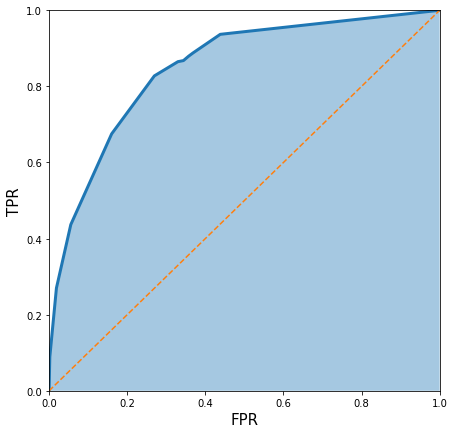

0.8594405083038122

In [104]:
best_thresh_curve(y_true=y_test,y_proba_score=p_df['blend10'])
roc_auc_score(y_test,p_df['blend10'])

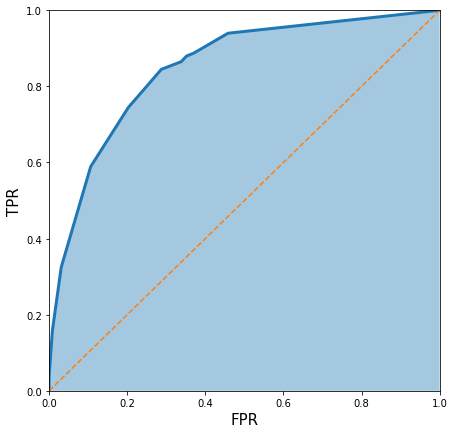

0.859291548853283

In [105]:
best_thresh_curve(y_true=y_test,y_proba_score=p_df['blend3'])
roc_auc_score(y_test,p_df['blend3'])

In [108]:
trained_models

{'xgb': {'model_': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=5000, n_jobs=-1, num_parallel_tree=1,
                random_state=34, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
                subsample=0.7, tree_method='exact', validate_parameters=1,
                verbosity=None),
  'dv_': DictVectorizer(sparse=False)},
 'Lgb': {'model_': LGBMClassifier(colsample_bytree=0.9, learning_rate=0.008, max_depth=5,
                 metric='binary_logloss', min_child_samples=10, n_estimators=5000,
                 num_leaves=120, random_state=34, reg_alpha=5, reg_lambda=2,
                 subsample=0.7, subsample_freq=2),
  'dv_': DictVectorizer(sp

In [109]:
import pickle 

with open('churn-models.bin', 'wb') as f_out:
    pickle.dump((trained_models['xgb'],trained_models['Lgb'],trained_models['Logistic_reg'],trained_models['bayes']), f_out) 

In [20]:
## opening
import pickle 
loaded_models ={}
with open('churn-models.bin', 'rb') as f_in:
    loaded_models['xgb'],loaded_models['Lgb'],loaded_models['Logis,tic_reg'],loaded_models['bayes',] = pickle.load(f_in)

NameError: name 'pickle' is not defined

In [115]:
loaded_models

{'xgb': {'model_': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=5000, n_jobs=-1, num_parallel_tree=1,
                random_state=34, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
                subsample=0.7, tree_method='exact', validate_parameters=1,
                verbosity=None),
  'dv_': DictVectorizer(sparse=False)},
 'Lgb': {'model_': LGBMClassifier(colsample_bytree=0.9, learning_rate=0.008, max_depth=5,
                 metric='binary_logloss', min_child_samples=10, n_estimators=5000,
                 num_leaves=120, random_state=34, reg_alpha=5, reg_lambda=2,
                 subsample=0.7, subsample_freq=2),
  'dv_': DictVectorizer(sp

In [118]:
p_df_train,p_df_test = metrics(trained_models,df_train_full,df_test)

===========xgb==========
===========Lgb==========
===========Logistic_reg==========
===========bayes==========


,Model Name,auc_train,auc_test,F1_Score_train,F1_Score_test,recall_train,recall_test
3,bayes,0.814952,0.835046,0.594069,0.589494,0.842867,0.870690
1,Lgb,0.916134,0.852163,0.711318,0.597285,0.652860,0.568966
0,xgb,0.900585,0.854690,0.675353,0.603604,0.613412,0.577586
2,Logistic_reg,0.842720,0.857239,0.597968,0.606061,0.541749,0.574713


In [119]:
p_df_train

,xgb,Lgb,Logistic_reg,bayes
0,0.011484,0.011976,0.059733,1.412030e-27
1,0.171605,0.208680,0.026937,4.088143e-05
2,0.008940,0.007762,0.008189,3.437242e-11
3,0.054917,0.051126,0.026273,3.764747e-06
4,0.063110,0.058609,0.059778,1.045496e-02
...,...,...,...,...
5629,0.873327,0.845359,0.809618,1.000000e+00
5630,0.006114,0.006865,0.003585,4.500905e-28
5631,0.637694,0.676833,0.631183,9.999960e-01
5632,0.477207,0.550858,0.493449,9.999692e-01


In [120]:
def blend_models(p_df):
    p_df['blend1'] = 0.3* p_df.Logistic_reg + 0.3*p_df.bayes + 0.2*p_df.xgb + 0.2*p_df.Lgb
    p_df['blend2'] = 0.25* p_df.Logistic_reg + 0.25*p_df.bayes + 0.25*p_df.xgb + 0.25*p_df.Lgb
    p_df['blend3'] = 0.4* p_df.Logistic_reg + 0.4*p_df.bayes + 0.1*p_df.xgb + 0.1*p_df.Lgb
    p_df['blend4'] = 0.3* p_df.Logistic_reg + 0.3*p_df.bayes + 0.3*p_df.xgb + 0.1*p_df.Lgb
    p_df['blend5'] = 0.4* p_df.Logistic_reg + 0.3*p_df.bayes + 0.2*p_df.xgb + 0.1*p_df.Lgb
    p_df['blend6'] = 0.3* p_df.Logistic_reg + 0.4*p_df.bayes + 0.2*p_df.xgb + 0.1*p_df.Lgb
    p_df['blend7'] = 0.35* p_df.Logistic_reg + 0.35*p_df.bayes + 0.25*p_df.xgb + 0.05*p_df.Lgb
    p_df['blend8'] = 0.35* p_df.Logistic_reg + 0.35*p_df.bayes + 0.2*p_df.xgb + 0.1*p_df.Lgb
    p_df['blend9'] = 0.5* p_df.Logistic_reg + 0.3*p_df.bayes + 0.1*p_df.xgb + 0.1*p_df.Lgb
    p_df['blend10'] = 0.3* p_df.Logistic_reg + 0.5*p_df.bayes + 0.1*p_df.xgb + 0.1*p_df.Lgb
    p_df['blend3_10'] = 0.5* p_df['blend3'] + 0.5* p_df['blend10']
    return p_df

In [122]:
blend_train = blend_models(p_df_train)
blend_train

,xgb,Lgb,Logistic_reg,bayes,blend1,blend2,blend3,blend4,blend5,blend6,blend7,blend8,blend9,blend10,blend3_10
0,0.011484,0.011976,0.059733,1.412030e-27,0.022612,0.020798,0.026239,0.022563,0.027388,0.021414,0.024376,0.024401,0.032213,0.020266,0.023253
1,0.171605,0.208680,0.026937,4.088143e-05,0.084150,0.101816,0.048820,0.080443,0.065976,0.063287,0.062778,0.064631,0.051509,0.046130,0.047475
2,0.008940,0.007762,0.008189,3.437242e-11,0.005797,0.006223,0.004946,0.005915,0.005840,0.005021,0.005489,0.005430,0.005765,0.004127,0.004536
3,0.054917,0.051126,0.026273,3.764747e-06,0.029092,0.033080,0.021115,0.029471,0.026606,0.023980,0.025483,0.025293,0.023742,0.018488,0.019802
4,0.063110,0.058609,0.059778,1.045496e-02,0.045414,0.047988,0.040265,0.045864,0.045531,0.040598,0.043290,0.043064,0.045197,0.035333,0.037799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0.873327,0.845359,0.809618,1.000000e+00,0.886623,0.882076,0.895716,0.889420,0.883049,0.902087,0.893966,0.892568,0.876678,0.914754,0.905235
5630,0.006114,0.006865,0.003585,4.500905e-28,0.003671,0.004141,0.002732,0.003596,0.003343,0.002985,0.003127,0.003164,0.003090,0.002373,0.002553
5631,0.637694,0.676833,0.631183,9.999960e-01,0.752259,0.736427,0.783924,0.748345,0.747694,0.784575,0.764178,0.766135,0.747043,0.820806,0.802365
5632,0.477207,0.550858,0.493449,9.999692e-01,0.653639,0.630371,0.700174,0.646273,0.647898,0.698550,0.669541,0.673224,0.649522,0.750826,0.725500


In [133]:
blend_test = blend_models(p_df_test)
blend_test

,xgb,Lgb,Logistic_reg,bayes,blend1,blend2,blend3,blend4,blend5,blend6,blend7,blend8,blend9,blend10,blend3_10
0,0.105963,0.116671,0.062243,1.829861e-03,0.063749,0.071677,0.047893,0.062678,0.058306,0.052265,0.054750,0.055285,0.053934,0.041851,0.044872
1,0.117438,0.135127,0.174739,6.308408e-06,0.102936,0.106827,0.095155,0.101168,0.106898,0.089424,0.097277,0.098161,0.112628,0.077681,0.086418
2,0.143232,0.117962,0.370267,9.999820e-01,0.463313,0.407861,0.574219,0.465840,0.488544,0.551515,0.521293,0.520030,0.511247,0.637190,0.605705
3,0.424163,0.408690,0.509361,9.999949e-01,0.619377,0.585552,0.687028,0.620925,0.629445,0.678508,0.654750,0.653976,0.637964,0.736091,0.711559
4,0.145723,0.136387,0.233679,6.765039e-02,0.146821,0.145860,0.148743,0.147754,0.156550,0.139947,0.148715,0.148249,0.165346,0.132140,0.140441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0.475891,0.465101,0.483615,9.999389e-01,0.633265,0.606137,0.687521,0.634344,0.635116,0.686748,0.661472,0.660932,0.635888,0.739153,0.713337
1405,0.017295,0.021345,0.060675,8.428175e-26,0.025930,0.024828,0.028134,0.025525,0.029863,0.023796,0.026627,0.026830,0.034201,0.022066,0.025100
1406,0.007949,0.005685,0.006380,1.904465e-12,0.004641,0.005004,0.003915,0.004867,0.004710,0.004072,0.004504,0.004391,0.004553,0.003277,0.003596
1407,0.163086,0.128333,0.165761,9.954102e-01,0.406635,0.363148,0.493610,0.410111,0.410378,0.493343,0.453598,0.451861,0.410646,0.576575,0.535093


In [135]:
def calculate_profit(y,y_pred,voucher,customer_lifetime_value):
    tp = np.where((y_pred==1) & (y==1) , (customer_lifetime_value - voucher),0)
    
    fp = np.where((y_pred==1) & (y==0) ,  - voucher,0)
    
    return np.sum([tp,fp])

In [136]:
def blend_check(p_df,y):    
    blends = [i for i in p_df.columns if 'blend' in i]
    row_index = 0
    model_table = pd.DataFrame()
    y_test = y #df_test.churn.values
    for blend in blends:
        preds = p_df[blend]
        preds_ =  (preds>= 0.5)*1
        model_table.loc[row_index, 'Model Name'] = blend
        model_table.loc[row_index, 'auc_test'] = roc_auc_score(y_test,preds)
        model_table.loc[row_index, 'recall_test'] = recall_score(y_test,preds_)
        model_table.loc[row_index, 'precision_test'] = precision_score(y_test,preds_)
        model_table.loc[row_index, 'F1_Score_test'] = f1_score(y_test,preds_)
        model_table.loc[row_index, 'profit'] = calculate_profit(y_test,preds_,1000,5000)
        model_table.loc[row_index, 'mean'] = model_table.loc[row_index,['auc_test','recall_test','precision_test','F1_Score_test']].mean()
        row_index+=1

    model_table.sort_values(by=['F1_Score_test'], ascending=True,inplace=True)

    display(model_table.style.background_gradient(cmap='summer_r'))    
    

In [137]:
blend_check(p_df_train,df_train_full.churn)

,Model Name,auc_test,recall_test,precision_test,F1_Score_test,profit,mean
9,blend10,0.862813,0.832347,0.476477,0.606032,651000.000000,0.694417
10,blend3_10,0.861523,0.825773,0.486068,0.611937,646000.000000,0.696325
2,blend3,0.860434,0.815253,0.512185,0.629122,611000.000000,0.704249
5,blend6,0.867374,0.817226,0.516410,0.632892,599000.000000,0.708476
6,blend7,0.865071,0.797502,0.547383,0.649184,522000.000000,0.714785
7,blend8,0.866291,0.797502,0.548125,0.649705,525000.000000,0.715406
8,blend9,0.858803,0.771203,0.568865,0.654759,498000.000000,0.713407
4,blend5,0.865415,0.774490,0.577734,0.661798,527000.000000,0.719859
3,blend4,0.871145,0.781065,0.588994,0.671566,521000.000000,0.728192
0,blend1,0.873263,0.783695,0.591563,0.674208,520000.000000,0.730682


In [156]:
p_df_train

,xgb,Lgb,Logistic_reg,bayes,blend1,blend2,blend3,blend4,blend5,blend6,blend7,blend8,blend9,blend10,blend3_10
0,0.011484,0.011976,0.059733,1.412030e-27,0.022612,0.020798,0.026239,0.022563,0.027388,0.021414,0.024376,0.024401,0.032213,0.020266,0.023253
1,0.171605,0.208680,0.026937,4.088143e-05,0.084150,0.101816,0.048820,0.080443,0.065976,0.063287,0.062778,0.064631,0.051509,0.046130,0.047475
2,0.008940,0.007762,0.008189,3.437242e-11,0.005797,0.006223,0.004946,0.005915,0.005840,0.005021,0.005489,0.005430,0.005765,0.004127,0.004536
3,0.054917,0.051126,0.026273,3.764747e-06,0.029092,0.033080,0.021115,0.029471,0.026606,0.023980,0.025483,0.025293,0.023742,0.018488,0.019802
4,0.063110,0.058609,0.059778,1.045496e-02,0.045414,0.047988,0.040265,0.045864,0.045531,0.040598,0.043290,0.043064,0.045197,0.035333,0.037799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0.873327,0.845359,0.809618,1.000000e+00,0.886623,0.882076,0.895716,0.889420,0.883049,0.902087,0.893966,0.892568,0.876678,0.914754,0.905235
5630,0.006114,0.006865,0.003585,4.500905e-28,0.003671,0.004141,0.002732,0.003596,0.003343,0.002985,0.003127,0.003164,0.003090,0.002373,0.002553
5631,0.637694,0.676833,0.631183,9.999960e-01,0.752259,0.736427,0.783924,0.748345,0.747694,0.784575,0.764178,0.766135,0.747043,0.820806,0.802365
5632,0.477207,0.550858,0.493449,9.999692e-01,0.653639,0.630371,0.700174,0.646273,0.647898,0.698550,0.669541,0.673224,0.649522,0.750826,0.725500


In [163]:
df_train_full

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges,predictions10,predictions3,pred10,pred3,profit10,profit3,training_data
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0,13.114213,6.674472e+04,0.606924,0.530594,1,1,-1000,-1000,Yes
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,yes,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1,42.767930,9.989076e+06,NaN,NaN,0,0,-1000,-1000,Yes
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,yes,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0,71.861090,2.191878e+07,0.060298,0.063392,0,0,-1000,-1000,Yes
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,no,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0,73.737273,3.970071e+07,0.022249,0.026424,0,0,-1000,-1000,Yes
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,yes,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0,29.044744,4.181003e+06,0.069532,0.071192,0,0,-1000,-1000,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0781-lkxbr,male,1,no,no,9,yes,yes,fiber_optic,no,no,yes,no,yes,yes,month-to-month,yes,electronic_check,100.50,918.60,1,9.140299,8.438260e+05,0.213749,0.200030,0,0,-1000,-1000,Yes
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0,59.644110,1.415862e+06,0.593506,0.518334,1,1,-1000,-1000,Yes
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1,28.188269,8.877420e+06,0.706261,0.652069,1,1,4000,4000,Yes
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,yes,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1,2.097426,1.301881e+04,0.020511,0.026251,0,0,-1000,-1000,Yes


In [154]:
p_df_test

,xgb,Lgb,Logistic_reg,bayes,blend1,blend2,blend3,blend4,blend5,blend6,blend7,blend8,blend9,blend10,blend3_10
0,0.105963,0.116671,0.062243,1.829861e-03,0.063749,0.071677,0.047893,0.062678,0.058306,0.052265,0.054750,0.055285,0.053934,0.041851,0.044872
1,0.117438,0.135127,0.174739,6.308408e-06,0.102936,0.106827,0.095155,0.101168,0.106898,0.089424,0.097277,0.098161,0.112628,0.077681,0.086418
2,0.143232,0.117962,0.370267,9.999820e-01,0.463313,0.407861,0.574219,0.465840,0.488544,0.551515,0.521293,0.520030,0.511247,0.637190,0.605705
3,0.424163,0.408690,0.509361,9.999949e-01,0.619377,0.585552,0.687028,0.620925,0.629445,0.678508,0.654750,0.653976,0.637964,0.736091,0.711559
4,0.145723,0.136387,0.233679,6.765039e-02,0.146821,0.145860,0.148743,0.147754,0.156550,0.139947,0.148715,0.148249,0.165346,0.132140,0.140441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0.475891,0.465101,0.483615,9.999389e-01,0.633265,0.606137,0.687521,0.634344,0.635116,0.686748,0.661472,0.660932,0.635888,0.739153,0.713337
1405,0.017295,0.021345,0.060675,8.428175e-26,0.025930,0.024828,0.028134,0.025525,0.029863,0.023796,0.026627,0.026830,0.034201,0.022066,0.025100
1406,0.007949,0.005685,0.006380,1.904465e-12,0.004641,0.005004,0.003915,0.004867,0.004710,0.004072,0.004504,0.004391,0.004553,0.003277,0.003596
1407,0.163086,0.128333,0.165761,9.954102e-01,0.406635,0.363148,0.493610,0.410111,0.410378,0.493343,0.453598,0.451861,0.410646,0.576575,0.535093


In [138]:
blend_check(p_df_test,df_test.churn.values)

,Model Name,auc_test,recall_test,precision_test,F1_Score_test,profit,mean
9,blend10,0.859441,0.864943,0.462366,0.602603,854000.000000,0.697338
10,blend3_10,0.859316,0.850575,0.469097,0.604699,849000.000000,0.695921
5,blend6,0.859736,0.839080,0.487479,0.616684,861000.000000,0.700745
2,blend3,0.859292,0.844828,0.490818,0.620908,871000.000000,0.703961
4,blend5,0.859831,0.772989,0.522330,0.623407,830000.000000,0.694639
6,blend7,0.859719,0.818966,0.505319,0.625000,861000.000000,0.702251
7,blend8,0.859814,0.818966,0.505319,0.625000,861000.000000,0.702275
8,blend9,0.859267,0.781609,0.521073,0.625287,838000.000000,0.696809
3,blend4,0.859663,0.772989,0.526419,0.626310,834000.000000,0.696345
0,blend1,0.859747,0.772989,0.527451,0.627040,835000.000000,0.696806


In [142]:
(651000.000000 - 611000.000000) / p_df_train.shape[0]

7.099751508697196

In [144]:
(871000.000000 - 854000.000000) /p_df_test.shape[0]

12.065294535131299

In [180]:
def merge_df(df,p_df,is_train):
    df = df.copy()
    #df_train_full['predictions10'] = p_df_train['blend10']
    #df_train_full['predictions3'] = p_df_train['blend3']
    df = pd.concat([df.reset_index(drop=True),p_df[['blend10','blend3']]],axis=1)
    df['pred10'] = np.where((df['blend10']>0.5),1,0)
    df['pred3'] = np.where((df['blend3']>0.5),1,0)
    df['profit10'] = np.where(
        (df.churn==1) & (df['pred10']==1) ,(5000-1000), # wanted to churn 1,1
                              np.where((df.churn==0) & (df['pred10']==0),5000, # 0,0
                                      np.where((df.churn==0) & (df['pred10']==1),-1000,-5000)
    ))
    
    df['profit3'] = np.where(
        (df.churn==1) & (df['pred3']==1) ,(5000-1000), # wanted to churn 1,1
                              np.where((df.churn==0) & (df['pred3']==0),5000, # 0,0
                                     np.where((df.churn==0) & (df['pred3']==1),-1000,-5000)
    )) 
    
    #for g , gp in df.groupby('profit10')['churn','pred10','profit10']:
        #print(g)
        #display(gp.head())
    
    df['training_data'] =is_train
    return df

In [173]:
p_df_train

,xgb,Lgb,Logistic_reg,bayes,blend1,blend2,blend3,blend4,blend5,blend6,blend7,blend8,blend9,blend10,blend3_10
0,0.011484,0.011976,0.059733,1.412030e-27,0.022612,0.020798,0.026239,0.022563,0.027388,0.021414,0.024376,0.024401,0.032213,0.020266,0.023253
1,0.171605,0.208680,0.026937,4.088143e-05,0.084150,0.101816,0.048820,0.080443,0.065976,0.063287,0.062778,0.064631,0.051509,0.046130,0.047475
2,0.008940,0.007762,0.008189,3.437242e-11,0.005797,0.006223,0.004946,0.005915,0.005840,0.005021,0.005489,0.005430,0.005765,0.004127,0.004536
3,0.054917,0.051126,0.026273,3.764747e-06,0.029092,0.033080,0.021115,0.029471,0.026606,0.023980,0.025483,0.025293,0.023742,0.018488,0.019802
4,0.063110,0.058609,0.059778,1.045496e-02,0.045414,0.047988,0.040265,0.045864,0.045531,0.040598,0.043290,0.043064,0.045197,0.035333,0.037799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0.873327,0.845359,0.809618,1.000000e+00,0.886623,0.882076,0.895716,0.889420,0.883049,0.902087,0.893966,0.892568,0.876678,0.914754,0.905235
5630,0.006114,0.006865,0.003585,4.500905e-28,0.003671,0.004141,0.002732,0.003596,0.003343,0.002985,0.003127,0.003164,0.003090,0.002373,0.002553
5631,0.637694,0.676833,0.631183,9.999960e-01,0.752259,0.736427,0.783924,0.748345,0.747694,0.784575,0.764178,0.766135,0.747043,0.820806,0.802365
5632,0.477207,0.550858,0.493449,9.999692e-01,0.653639,0.630371,0.700174,0.646273,0.647898,0.698550,0.669541,0.673224,0.649522,0.750826,0.725500


In [182]:
train_out = merge_df(df=df_train_full,p_df=p_df_train,is_train='Yes')

-5000


,churn,pred10,profit10
1,1,0,-5000
5,1,0,-5000
31,1,0,-5000
35,1,0,-5000
116,1,0,-5000


-1000


,churn,pred10,profit10
7,0,1,-1000
8,0,1,-1000
12,0,1,-1000
20,0,1,-1000
23,0,1,-1000


4000


,churn,pred10,profit10
9,1,1,4000
13,1,1,4000
19,1,1,4000
22,1,1,4000
27,1,1,4000


5000


,churn,pred10,profit10
0,0,0,5000
2,0,0,5000
3,0,0,5000
4,0,0,5000
6,0,0,5000


In [184]:
test_out = merge_df(df=df_test,p_df=p_df_test,is_train='No')

-5000


,churn,pred10,profit10
51,1,0,-5000
65,1,0,-5000
100,1,0,-5000
169,1,0,-5000
179,1,0,-5000


-1000


,churn,pred10,profit10
2,0,1,-1000
6,0,1,-1000
7,0,1,-1000
9,0,1,-1000
10,0,1,-1000


4000


,churn,pred10,profit10
3,1,1,4000
12,1,1,4000
21,1,1,4000
30,1,1,4000
35,1,1,4000


5000


,churn,pred10,profit10
0,0,0,5000
1,0,0,5000
4,0,0,5000
5,0,0,5000
8,0,0,5000


In [203]:
train_out

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges,blend10,blend3,pred10,pred3,profit10,profit3,training_data
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0,13.114213,6.674472e+04,0.020266,0.026239,0,0,5000,5000,Yes
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,yes,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1,42.767930,9.989076e+06,0.046130,0.048820,0,0,-5000,-5000,Yes
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,yes,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0,71.861090,2.191878e+07,0.004127,0.004946,0,0,5000,5000,Yes
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,no,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0,73.737273,3.970071e+07,0.018488,0.021115,0,0,5000,5000,Yes
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,yes,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0,29.044744,4.181003e+06,0.035333,0.040265,0,0,5000,5000,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0781-lkxbr,male,1,no,no,9,yes,yes,fiber_optic,no,no,yes,no,yes,yes,month-to-month,yes,electronic_check,100.50,918.60,1,9.140299,8.438260e+05,0.914754,0.895716,1,1,4000,4000,Yes
5630,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0,59.644110,1.415862e+06,0.002373,0.002732,0,0,5000,5000,Yes
5631,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1,28.188269,8.877420e+06,0.820806,0.783924,1,1,4000,4000,Yes
5632,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,yes,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1,2.097426,1.301881e+04,0.750826,0.700174,1,1,4000,4000,Yes


In [185]:
train_out.profit10.sum(),train_out.profit3.sum()

(16008000, 17034000)

In [186]:
test_out.profit10.sum(),test_out.profit3.sum()

(4174000, 4381000)

### global churn rate

In [213]:
global_churn = round(train_out.churn.mean(),2)
global_churn

0.27

In [218]:
for_dashboard['profit_without_model'] = np.where((for_dashboard.churn==0),5000,-5000)

In [219]:
for_dashboard 

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,total_charges_per_month,tenure_totalcharges,blend10,blend3,pred10,pred3,profit10,profit3,training_data,profit_without_model
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0,13.114213,6.674472e+04,0.020266,0.026239,0,0,5000,5000,Yes,5000
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,yes,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1,42.767930,9.989076e+06,0.046130,0.048820,0,0,-5000,-5000,Yes,-5000
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,yes,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0,71.861090,2.191878e+07,0.004127,0.004946,0,0,5000,5000,Yes,5000
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,no,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0,73.737273,3.970071e+07,0.018488,0.021115,0,0,5000,5000,Yes,5000
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,yes,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0,29.044744,4.181003e+06,0.035333,0.040265,0,0,5000,5000,Yes,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,5130-iekqt,male,1,no,no,25,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,month-to-month,no,mailed_check,105.95,2655.25,1,25.061350,7.050353e+06,0.739153,0.687521,1,1,4000,4000,No,-5000
1405,4452-rohmo,female,0,no,no,15,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.60,331.60,0,16.918367,1.099586e+05,0.022066,0.028134,0,0,5000,5000,No,5000
1406,6164-haqtx,male,0,no,no,71,no,no_phone_service,dsl,yes,yes,yes,yes,yes,no,two_year,no,bank_transfer_(automatic),53.95,3888.65,0,72.078777,1.512160e+07,0.003277,0.003915,0,0,5000,5000,No,5000
1407,3982-dqlus,male,1,yes,yes,65,yes,yes,fiber_optic,yes,yes,no,no,no,no,month-to-month,yes,electronic_check,85.75,5688.45,0,66.337609,3.235846e+07,0.576575,0.493610,1,0,-1000,5000,No,5000


<AxesSubplot:>

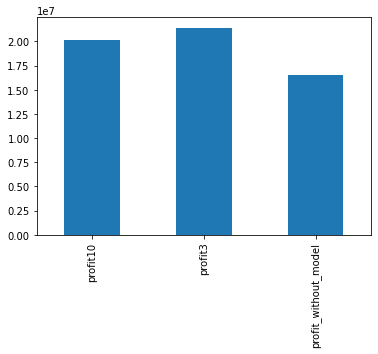

In [223]:
for_dashboard[['profit10','profit3','profit_without_model']].sum().plot(kind='bar')

In [225]:
def Dict_df(df):
    df = df.copy()
    
    dv_X = DictVectorizer(sparse=False)
    ds = df[categorical + numerical].to_dict(orient='records')
    dv_X.fit(ds)
    Xs = pd.DataFrame(dv_X.transform(ds))
    Xs.columns = dv_X.get_feature_names()
    return Xs

In [226]:
df_dict = Dict_df(df=train_out)
df_dict.head()

,contract=month-to-month,contract=one_year,contract=two_year,dependents=no,dependents=yes,deviceprotection=no,deviceprotection=no_internet_service,deviceprotection=yes,gender=female,gender=male,internetservice=dsl,internetservice=fiber_optic,internetservice=no,monthlycharges,multiplelines=no,multiplelines=no_phone_service,multiplelines=yes,onlinebackup=no,onlinebackup=no_internet_service,onlinebackup=yes,onlinesecurity=no,onlinesecurity=no_internet_service,onlinesecurity=yes,paperlessbilling=no,paperlessbilling=yes,partner=no,partner=yes,paymentmethod=bank_transfer_(automatic),paymentmethod=credit_card_(automatic),paymentmethod=electronic_check,paymentmethod=mailed_check,phoneservice=no,phoneservice=yes,seniorcitizen,streamingmovies=no,streamingmovies=no_internet_service,streamingmovies=yes,streamingtv=no,streamingtv=no_internet_service,streamingtv=yes,techsupport=no,techsupport=no_internet_service,techsupport=yes,tenure,totalcharges
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,19.70,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,12.0,258.35
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,73.90,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,42.0,3160.55
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,65.15,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,71.0,4681.75
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,85.45,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,71.0,6300.85
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,70.40,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,30.0,2044.75


In [231]:
df_dict2 = Dict_df(df=test_out)
df_dict2.head()

,contract=month-to-month,contract=one_year,contract=two_year,dependents=no,dependents=yes,deviceprotection=no,deviceprotection=no_internet_service,deviceprotection=yes,gender=female,gender=male,internetservice=dsl,internetservice=fiber_optic,internetservice=no,monthlycharges,multiplelines=no,multiplelines=no_phone_service,multiplelines=yes,onlinebackup=no,onlinebackup=no_internet_service,onlinebackup=yes,onlinesecurity=no,onlinesecurity=no_internet_service,onlinesecurity=yes,paperlessbilling=no,paperlessbilling=yes,partner=no,partner=yes,paymentmethod=bank_transfer_(automatic),paymentmethod=credit_card_(automatic),paymentmethod=electronic_check,paymentmethod=mailed_check,phoneservice=no,phoneservice=yes,seniorcitizen,streamingmovies=no,streamingmovies=no_internet_service,streamingmovies=yes,streamingtv=no,streamingtv=no_internet_service,streamingtv=yes,techsupport=no,techsupport=no_internet_service,techsupport=yes,tenure,totalcharges
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,79.85,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,41.0,3320.75
1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,102.40,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,66.0,6471.85
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,45.00,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,12.0,524.35
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,50.60,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,249.95
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,65.90,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,10.0,660.05


In [227]:
from sklearn.feature_selection import mutual_info_classif
def make_mi_scores_Classifier(X_train, y_train):
    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X_train.dtypes == int
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(20,14))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

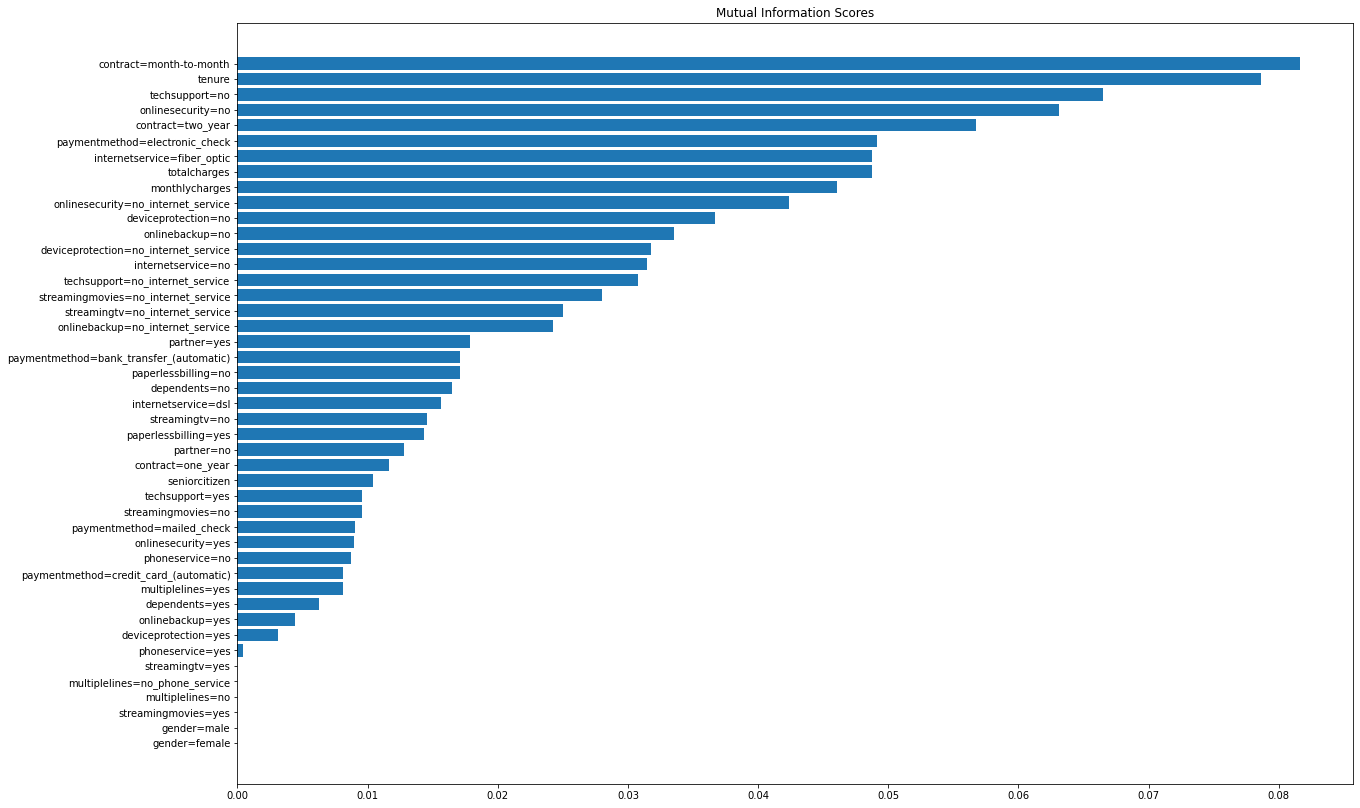

In [229]:
mi_scores = make_mi_scores_Classifier(X_train=df_dict, y_train=train_out.churn)
plot_mi_scores(scores=mi_scores)

In [230]:
mi_scores.to_dict()

{'contract=month-to-month': 0.0816523790132817,
 'tenure': 0.07864993326103331,
 'techsupport=no': 0.06650525932710138,
 'onlinesecurity=no': 0.0631499838454983,
 'contract=two_year': 0.05671559591189368,
 'paymentmethod=electronic_check': 0.04912287754138478,
 'internetservice=fiber_optic': 0.04872698513173135,
 'totalcharges': 0.04871443048119284,
 'monthlycharges': 0.04602690325152525,
 'onlinesecurity=no_internet_service': 0.04235904425187731,
 'deviceprotection=no': 0.03665232586000888,
 'onlinebackup=no': 0.03355094233778688,
 'deviceprotection=no_internet_service': 0.03176536770977112,
 'internetservice=no': 0.03146335536264466,
 'techsupport=no_internet_service': 0.030736934823861972,
 'streamingmovies=no_internet_service': 0.027976868404509858,
 'streamingtv=no_internet_service': 0.024993006586522704,
 'onlinebackup=no_internet_service': 0.024271899515621254,
 'partner=yes': 0.01787592534342286,
 'paymentmethod=bank_transfer_(automatic)': 0.017133086539485642,
 'paperlessbilli

In [233]:
loaded_models['xgb']['model_']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=-1, num_parallel_tree=1,
              random_state=34, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [235]:
#X = df_dict2
#y= preds_df_train['log_target']
#train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

#my_model = RandomForestRegressor(n_estimators=100,random_state=0).fit(train_X, train_y)

#calculate and show importances with the eli5 library:
import eli5
from eli5.sklearn import PermutationImportance
features = df_dict2.columns
perm = PermutationImportance(loaded_models['xgb']['model_'], random_state=1).fit(df_dict2,test_out.churn )
eli5.show_weights(perm, feature_names = features.tolist())

Weight,Feature
0.0312 ± 0.0112,contract=month-to-month
0.0230 ± 0.0083,tenure
0.0084 ± 0.0048,paperlessbilling=no
0.0068 ± 0.0117,totalcharges
0.0058 ± 0.0110,monthlycharges
0.0057 ± 0.0088,internetservice=fiber_optic
0.0045 ± 0.0061,onlinesecurity=no
0.0034 ± 0.0039,multiplelines=no
0.0028 ± 0.0016,multiplelines=no_phone_service
0.0020 ± 0.0024,paperlessbilling=yes


In [ ]:
0.0312 ± 0.0112	contract=month-to-month
0.0230 ± 0.0083	tenure
0.0084 ± 0.0048	paperlessbilling=no
0.0068 ± 0.0117	totalcharges
0.0058 ± 0.0110	monthlycharges
0.0057 ± 0.0088	internetservice=fiber_optic
0.0045 ± 0.0061	onlinesecurity=no
0.0034 ± 0.0039	multiplelines=no
0.0028 ± 0.0016	multiplelines=no_phone_service
0.0020 ± 0.0024	paperlessbilling=yes
0.0017 ± 0.0014	deviceprotection=yes
0.0013 ± 0.0017	partner=no
0.0010 ± 0.0039	paymentmethod=bank_transfer_(automatic)
0.0009 ± 0.0017	partner=yes
0.0007 ± 0.0053	contract=two_year
0.0007 ± 0.0038	contract=one_year
0.0006 ± 0.0051	dependents=no
0.0006 ± 0.0006	onlinebackup=no_internet_service
0.0003 ± 0.0025	onlinesecurity=yes
0.0003 ± 0.0026	paymentmethod=mailed_check

In [224]:
for_dashboard.to_csv('for_churn_dashboard.csv',index='False')

In [16]:
def preprocessing_single(single_dict):
    df = pd.DataFrame(single_dict,index=[0])

    df.columns = df.columns.str.lower().str.replace(' ', '_')

    string_columns = list(df.dtypes[df.dtypes == 'object'].index)

    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(' ', '_')

    df.churn = (df.churn == 'yes').astype(int)
    
    df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
    df['totalcharges'] = df['totalcharges'].fillna(0)
    return df

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='rows')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [2]:
df_test

NameError: name 'df_test' is not defined

In [18]:
ps1 = preprocessing_single(d1)

In [31]:
## opening
import pickle 
loaded_models ={}
with open('churn-models.bin', 'rb') as f_in:
    loaded_models['xgb'],loaded_models['Lgb'],loaded_models['Logistic_reg'],loaded_models['bayes'] = pickle.load(f_in)

In [32]:
loaded_models

{'xgb': {'model_': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=5000, n_jobs=-1, num_parallel_tree=1,
                random_state=34, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
                subsample=0.7, tree_method='exact', validate_parameters=1,
                verbosity=None),
  'dv_': DictVectorizer(sparse=False)},
 'Lgb': {'model_': LGBMClassifier(colsample_bytree=0.9, learning_rate=0.008, max_depth=5,
                 metric='binary_logloss', min_child_samples=10, n_estimators=5000,
                 num_leaves=120, random_state=34, reg_alpha=5, reg_lambda=2,
                 subsample=0.7, subsample_freq=2),
  'dv_': DictVectorizer(sp

In [34]:
def predict_single(trained_models,df_single):
    preds_table_single = pd.DataFrame()
    for model_name in trained_models: 
            #print(f"==========={model_name}==========")
            model = trained_models[model_name]['model_']
            dv = trained_models[model_name]['dv_']
            
            y_pred_single = predict(df_single, dv, model)
            
            preds_table_single[model_name] = y_pred_single
            #preds_single =  (y_pred_single>= 0.5)*1
    p_df = preds_table_single.copy()
    p_df['blend3'] = 0.4* p_df.Logistic_reg + 0.4*p_df.bayes + 0.1*p_df.xgb + 0.1*p_df.Lgb
    #p_df['blend10'] = 0.3* p_df.Logistic_reg + 0.5*p_df.bayes + 0.1*p_df.xgb + 0.1*p_df.Lgb
    preds_single =  (p_df['blend3']>= 0.5)*1
    
    return     p_df['blend3'] , preds_single

In [33]:
predict_single(trained_models=loaded_models,df_single=ps1)

===========xgb==========
===========Lgb==========
===========Logistic_reg==========
===========bayes==========


(0    0.78635
 Name: blend3, dtype: float64,
 0    1
 Name: blend3, dtype: int32)